# Normalisation Histogram
## Manual Contrast Stretching
Task:

- Read cameraman.png as grayscale.

- Find the real min and max pixel values in the image.

- Implement the Linear Stretching Formula manually using Numpy (No cv.normalize).

- Show the original and the new image side-by-side.

- Constraint: Do not use for loops. Use Numpy vectorization.

    - important note:

        ```text
        # WRONG (uint8 overflow risk)
        # res = (img - min_val) * 255 / (max_val - min_val) 

        # CORRECT
        img_float = img.astype(float)
        res = (img_float - min_val) * 255.0 / (max_val - min_val)
        res_uint8 = res.astype(np.uint8)
        ```

(np.float64(-0.5), np.float64(250.5), np.float64(250.5), np.float64(-0.5))

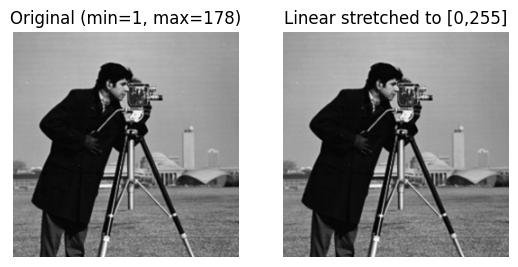

In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# cv.IMREAD_GRAYSCALE is the same as 0 for reading an image in grayscale mode
cameraman_img = cv.imread("img/cameraman2.png", cv.IMREAD_GRAYSCALE)
# cameraman_img=cv.imread("img/cameraman2.png",0)

# to prevent overflow risk I change image type to float before calculating normalization
cameraman_img_float = cameraman_img.astype(float)
min_val = cameraman_img.min()
max_val = cameraman_img.max()
new_image = (cameraman_img_float - min_val) * 255 / (max_val - min_val)

# change new_image type to uint8
new_image_uint8 = new_image.astype(np.uint8)

plt.subplot(1, 2, 1)
plt.title(f"Original (min={min_val}, max={max_val})")
plt.imshow(cameraman_img, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Linear stretched to [0,255]")
plt.imshow(new_image_uint8, cmap="gray")
plt.axis("off")

# Equalisation Histogram
- OpenCV Way (Black Box)
    ```bash
    equalized_img = cv.equalizeHist(img)
    ```
- numpy way:
    1. Get Histogram
        ```bash
        hist, bins = np.histogram(img.flatten(), 256, [0,256])
        ```

    2. Get CDF
        ```bash
        cdf = hist.cumsum()
        ```

    3. Normalize CDF (so max is 255)
        ```bash
        cdf_normalized = cdf * 255 / cdf.max()
        ```

    4. Map
    - We use the CDF as a "Look Up Table" (LUT).
    - If pixel value is 'v', new value is cdf_normalized[v]
        ```bash
        equalized_img = cdf_normalized[img]
        ```

Conceptual Question: 

Imagine an image that contains only two values: 50% of pixels are Black (0) and 50% of pixels are White (255).

1. What does the Histogram look like?

2. What does the CDF look like? (at 0, at 128, at 255)

3. If we apply Histogram Equalization to this specific image, will it change?

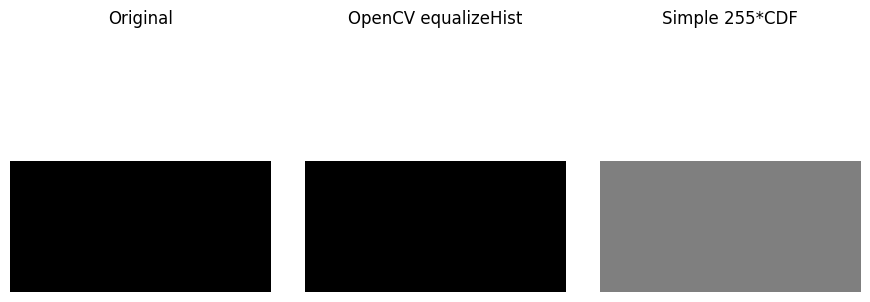

LUT_simple[0] = 127 LUT_simple[255] = 255


In [74]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

img = np.zeros((10, 10), dtype=np.uint8)
img[0:5, :] = 255

# histogram + CDF
hist = np.bincount(img.ravel(), minlength=256)
cdf = hist.cumsum() / hist.sum()

# "simplified" equalization LUT: new = 255 * CDF(old)
lut_simple = np.floor(255 * cdf).astype(np.uint8)

eq_simple = lut_simple[img]                 # apply LUT
eq_opencv = cv.equalizeHist(img)            # OpenCV equalization

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(img, cmap="gray", vmin=0, vmax=255); plt.axis("off")
plt.subplot(1,3,2); plt.title("OpenCV equalizeHist"); plt.imshow(eq_opencv, cmap="gray", vmin=0, vmax=255); plt.axis("off")
plt.subplot(1,3,3); plt.title("Simple 255*CDF"); plt.imshow(eq_simple, cmap="gray", vmin=0, vmax=255); plt.axis("off")
plt.tight_layout(); plt.show()

print("LUT_simple[0] =", lut_simple[0], "LUT_simple[255] =", lut_simple[255])
